In [53]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from importlib import reload
import anarhlyzer as ana
reload(ana)
fs = 48e3
s = ana.Sweeper()
s.designSweep(length=2,startFrequency=1.)
s.numHarmonics = 7
# s.singleSweep(1,[1],0.99)

59


(32769,) (32769, 1)


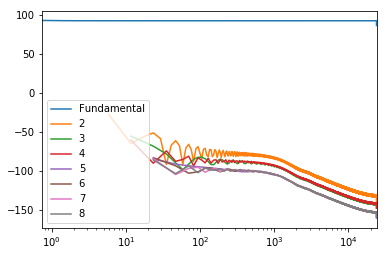

In [56]:
# s.singleSweep(1,[1],0.2)
# s.singleSweep(2,[1],0.2)
# plt.plot(ana.softclip(s.sweep, -0.3, 0.3))
# s.softSweep(lambda x: ana.softclip(x, -0.2, 0.5, 10))
def oversampledSoftclip(x):
    OSF = 10
    xx = sig.resample_poly(x,OSF,1)
    return sig.resample_poly(ana.softclip(xx, -0.2, 0.10, 0.2), 1, OSF)
# s.softSweep(oversampledSoftclip, plotFlag=False)
s.softSweep()
s.processSweeps()
s.plotAmplitudeResponses()

(6038, 1)


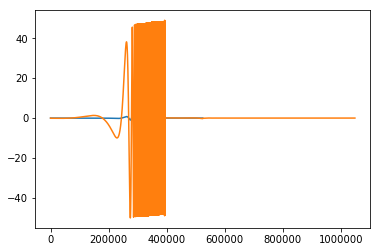

In [57]:
# s.plotIRs([4])
# plt.xlim(0,30)
# plt.plot(ana.db(np.abs(sig.hilbert(s.harmIrList[-1][0]))))
plt.plot(s.measurementList[-1].recording)
# yhat = s.volterraApprox(s.sweep[:,np.newaxis])
x = s.sweep[:,np.newaxis]
y = sig.fftconvolve(s.irList[-1], x)/np.sqrt(2*np.pi)
print(s.harmIrList[-1][0].shape)
y2 = sig.fftconvolve(s.harmIrList[-1][0], 0.5 * np.square(x) - 0.5)/np.sqrt(2*np.pi)
# y[:y2.shape[0]] += y2
plt.plot(y)
# plt.xlim(0, 100)
plt.show()

[      0       1       2 ..., 2097149 2097150 2097151] (2097152, 1)
(2097151, 1)
(1, 549, 9362)


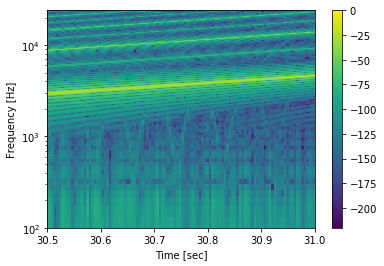

In [27]:
y = s.measurementList[-1].recording[:]
tmp = np.nonzero(np.abs(y) > 0.15 * np.max(np.abs(y)))[0]
print(tmp, y.shape)
start = int(tmp[0])
end = int(tmp[-1])
print(y[start:end].shape)
f, t, Sxx = sig.spectrogram(
    y[start:end].T, s.fs, nfft=1096, detrend='linear')
print(Sxx.shape)
plt.pcolormesh(t, f, ana.db(np.reshape(Sxx,Sxx.shape[1:])))
plt.yscale('log')
plt.ylim(100, 24e3)
plt.xlim(30.5,31)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.clim(-220, 0)
plt.colorbar()
plt.show()

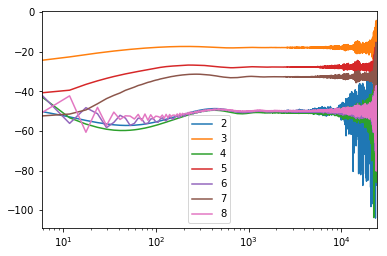

In [22]:
s.plotHDcurves()

[524288.0, 515279.59610466735, 510010.01763454737, 506271.19220933475, 503371.1339053344, 501001.61373921478, 498998.21298455505, 497262.7883140021, 495732.03526909481, 494362.7300100018, 493124.0427310309, 491993.20984388213]


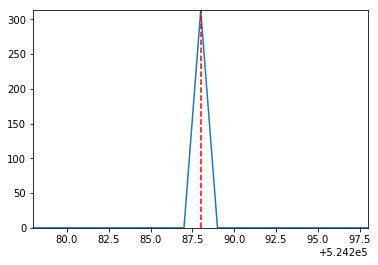

In [58]:
xy = sig.fftconvolve(s.measurementList[-1].recording, s.invSweep[:, np.newaxis])
# print(xinv.shape)
xLength = s.invSweep.shape[0]
# plt.plot(db(xy))
ymax = np.max(ana.db(xy))
# print('Argmax:',np.abs(xy).argmax()-xLength)
NT60 = int(65e3)
# plt.ylim(ymax-100,ymax)
# # plt.xlim(xLength,xLength+10000)
# plt.show()
# plt.plot()
maxIdxRaw = np.abs(xy).argmax()
# Distortion product pre-delays
# Sweeprate in nffts pr octave
harmonicsIdxs = [np.abs(xy).argmax() - np.log2(i+1) * s.sweepRate * s.nfft for i in range(12)]
print(harmonicsIdxs)
plt.plot(xy)
plt.xlim(harmonicsIdxs[-1]-100,harmonicsIdxs[0]-10)

for idx in harmonicsIdxs:
    plt.axvline(x=idx, color='red', linestyle='--')
NN = 0
plt.xlim(harmonicsIdxs[NN]-10,harmonicsIdxs[NN]+10)
def auto_y():
    xmin, xmax = plt.xlim()
    lines = plt.gca().get_lines()
    x,y = lines[0].get_data()
    tmp = y[np.logical_and(x > xmin, x < xmax)]
    plt.ylim(np.min(tmp), np.max(tmp))
auto_y()
plt.show()

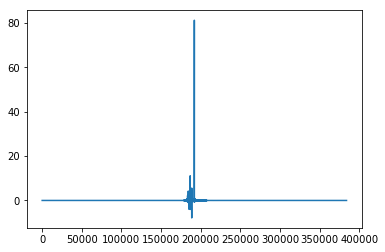

In [168]:
# Distortion product / Volterrra model fitting
plt.plot(xy)
# plt.xlim(0, 600)

In [5]:
(s.measurementList[-1].recording)

array([[-0.        ],
       [-0.        ],
       [-0.        ],
       ..., 
       [-0.00044401],
       [-0.00147922],
       [-0.00139718]])

In [360]:
x = s.irList[-1].T
x2 = s.irList[-2].T
x

array([[ -1.81490058e-03,  -3.03963858e-04,   6.50520733e-04, ...,
          1.97703172e-03,  -1.93630288e-03,   4.08880133e-05]])

In [358]:
# X = np.fft.fft(x)
# X

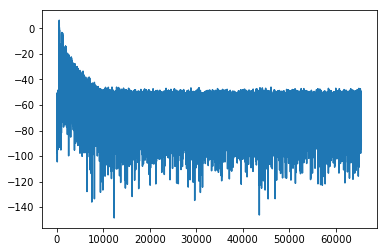

In [361]:
plt.plot(ana.db(x.T))

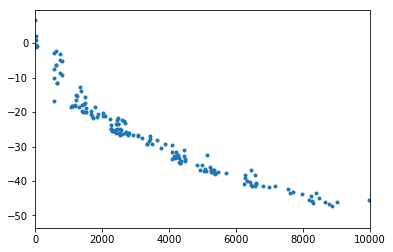

In [601]:
# Estimate T60
xc = x.T[np.abs(x).argmax():]
# plt.plot(ana.db(np.abs(xc)))
# Find local maxima (recursively)
def recursiveArgMaxs(x, n=2, cmpFcn=np.greater):
    outMaxs = sig.argrelextrema(x, cmpFcn)[0]
    for i in range(n-1):
        outMaxs = outMaxs[sig.argrelextrema(x[outMaxs], cmpFcn)[0]]
    return outMaxs

def envPreprocess(x):
    env = sig.hilbert(x.T).T[np.abs(x).argmax():].T
    env_db = ana.db(env)
    idxMs = recursiveArgMaxs(env_db.T, 1)
    # Further trim some outliers
    # Make it monotonic: remove any outlier below future bin maximum
    idx = np.arange(x.shape[0])
    N = 300
    lookAhead = 3 # Look ahead three bins
    binMaxs = np.zeros((int(2*np.floor(x.shape[0]/(N)+1)),1))
    for i in range(0, x.shape[0], int(N/2)):
        a = idxMs[np.logical_and(idxMs > i, idxMs < i + N)]
        if a.shape[0] == 0:
            continue
        binMaxs[int(2*i/N)] = np.max(env_db.T[a])
    removeList = []
    for i, idxM in enumerate(idxMs):
        if env_db.T[idxM] < binMaxs[int(np.floor(2*idxM/N + lookAhead))]:
            removeList.append(i)
    idxMs = np.delete(idxMs, removeList)
    return idxMs, env_db

idxMs, env = envPreprocess(x.T)
idxMs2, env2 = envPreprocess(x2.T)
# plt.plot(envSmooth.T)
plt.plot(idxMs,env.T[idxMs],marker='.', linestyle='None')
# idxMs2, env2 = envPreprocess(x2.T)
# plt.plot(idxMs2,env2.T[idxMs2],marker='.', linestyle='None')
plt.xlim(0,10000)
plt.show()

Number of GN iterations: 76
[[ -4.76257555e+01]
 [ -5.53336880e-03]
 [ -8.21314448e+00]]


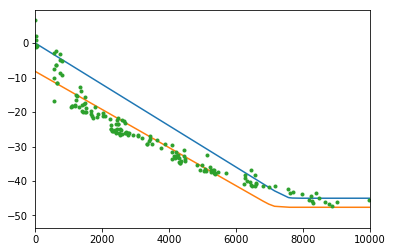

In [602]:
def fitLinConstLogSumExp(x, y, theta = [3e-40, -5e-3, 0]):  
    x = x.reshape(y.shape)
    N = x.shape[0]
    theta = np.array(theta)
    theta = theta.reshape((3, 1))
    grad = np.ones((3,1))
    i = 0;
    while np.max(np.abs(grad)) > 1e-9:
        qhat = np.exp(2 * theta[0]) + np.exp(2 * theta[1] * x + 2 * theta[2])
        yhat = 0.5 * np.log(qhat)
        r = y - yhat
        dqd0 = np.exp(2 * theta[0]) * np.ones(x.shape)
        dqd1 = 2 * x * np.exp(2 * theta[1] * x + 2 * theta[2])
        dqd2 = 2 * np.exp(2 * theta[1] * x + 2 * theta[2])
        J = np.array((dqd0,dqd1,dqd2))
        J = J.reshape((J.shape[0],J.shape[1])).T
        J = 0.5 * J / qhat
#         u, s, v = np.linalg.svd(J)
#         print(s)
        grad = J.T.dot(r)
#         if i % 300 is 2:
#             print(grad.T)
#             print('r=',r)
        update = np.linalg.solve(J.T.dot(J) + 1e1*np.eye(3), grad)
#         print(update)
        theta = theta + 0.5*update
        i += 1
    print('Number of GN iterations:', i)
    return theta
#         print(grad)
def evalLinConstLSE(x, theta):
    qhat = np.exp(2*theta[0]) + np.exp(2*theta[2]) * np.exp(2 * theta[1] * x)
#     print(qhat)
    yhat = 0.5 * np.log(qhat)
    return yhat
ids = idxMs[:]
theta = fitLinConstLogSumExp(ids, env.T[ids],[-45, -0.006, 0])
yhat = evalLinConstLSE(ids, [-45, -0.006, 0])
# print(yhat)
print(theta)
plt.plot(ids,yhat)
yhat = evalLinConstLSE(ids, theta)
plt.plot(ids,yhat)
plt.plot(ids,env.T[ids], marker='.', linestyle='None')
plt.xlim(0, 10000)
plt.show()

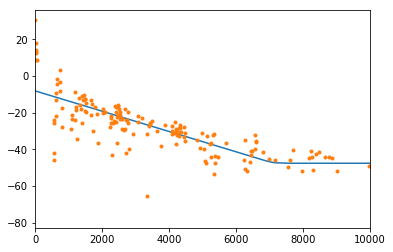

In [587]:
plt.plot(ids,yhat)
plt.plot(ids,envSmooth.T[ids], marker='.', linestyle='None')
plt.xlim(0, 10000)
plt.show()

In [588]:
ff, tt, Sxx = sig.spectrogram(xc, int(48e3))

In [169]:
def fit2LinConstLogSumExp(x, y, theta = None, p=2):
    stepSize = 0.1
    if theta is None:
        theta = [np.mean(y[-5:]), -1e-3, np.mean(y[:5]), -2e-4, np.mean(y[:5]) - 5]
    x = x.reshape(y.shape)
    N = x.shape[0]
    theta = np.array(theta)
    theta = theta.reshape((theta.shape[0], 1))
    grad = np.ones((theta.shape[0],1))
    i = 0;
    gradNorm = np.max(np.abs(grad))
    oldGradNorm = 10 * gradNorm
    while  gradNorm > 1e-8 and gradNorm != oldGradNorm:
        
        # Enforce constraints
        if theta[1] > 0:
            theta[1] = -theta[1]
        if theta[3] > 0:
            theta[3] = -theta[3]
        if theta[3] < theta[1]:
            print('SWRITCH')
            tmp = theta[3]
            theta[3] = theta[1]
            theta[1] = tmp
            tmp = theta[2]
            theta[2] = theta[4]
            theta[4] = tmp
        if theta[3] == theta[1]:
            theta[3] = 0.5 * theta[1]
        # Compute model
        qhat = (np.exp(p*theta[0]) 
                + np.exp(p*theta[2]) * np.exp(p * theta[1] * x)
                + np.exp(p*theta[4]) * np.exp(p * theta[3] * x))
        yhat = np.log(qhat) / p
        r = y - yhat # Residual
        # Derivatives:
        dqd0 = np.exp(p * theta[0]) * np.ones(x.shape)
        dqd1 = p * x * np.exp(p * theta[1] * x + p * theta[2])
        dqd2 = p * np.exp(p * theta[1] * x + p * theta[2])
        dqd3 = p * x * np.exp(p * theta[3] * x + p * theta[4])
        dqd4 = p * np.exp(p * theta[3] * x + p * theta[4])        
        J = np.array((dqd0,dqd1,dqd2,dqd3,dqd4))
        J = J.reshape((J.shape[0],J.shape[1])).T
        J = J / qhat / p
        grad = J.T.dot(r)
        oldGradNorm = gradNorm
        gradNorm = np.max(np.abs(grad))
        # GN update
        update = np.linalg.solve(J.T.dot(J) + np.eye(5), grad)
#         print(update)
        theta += stepSize * update / p
#         print(theta)
        i += 1
        if i > 10000 and i % 10000 == 0:
            stepSize /= 10
        if i > 100000:
            break
#     print('Number of GN iterations:', i)
#     print(grad.T)
    print('norm(r) =', np.linalg.norm(r))
    return theta
#         print(grad)
def eval2LinConstLSE(x, theta, p=2):
    qhat = (np.exp(p*theta[0]) 
            + np.exp(p*theta[2]) * np.exp(p * theta[1] * x)
            + np.exp(p*theta[4]) * np.exp(p * theta[3] * x))
#     print(qhat)
    yhat = np.log(qhat) / p
    return yhat
def estimateT60(ir, fs=48e3, p=2):
    idxMs, env = envPreprocess(ir.T)
    theta = fit2LinConstLogSumExp(idxMs, env.T[idxMs], None, p)
    return -60 / (theta[3] * fs)

ids = idxMs
p = 2
print('T60', estimateT60(s.irList[-1].T, s.fs, p))
print('T60', estimateT60(s.irList[-2].T, s.fs, p))
tt = np.arange(x.shape[1])
# theta = fit2LinConstLogSumExp(ids, env.T[ids],[-45, -0.006, 0, -1e-3, -20], p)
# print(theta)
# [[ -4.75651808e+01]
#  [ -9.07386617e-03]
#  [ -1.30959143e+00]
#  [ -3.27587337e-03]
#  [ -1.81847536e+01]
yhat = eval2LinConstLSE(tt, [-45, -0.006, 0, -2e-3, -20], p)
# print(yhat)
# for p in np.linspace(2,0.2,20):
#     theta = fit2LinConstLogSumExp(idxMs2, env2.T[idxMs2], None, p)
#     print(p, 'T60:', -60 / (theta[3] * s.fs))
# print(theta)
plt.plot(tt,yhat)
yhat = eval2LinConstLSE(tt, theta, p)
plt.plot(tt,yhat)
# plt.plot(env.T, marker='.', linestyle='None')
plt.plot(ids,env.T[ids], marker='.', linestyle='None')
plt.xlim(0, 15000)
plt.show()

NameError: name 'idxMs' is not defined

(0, 600)

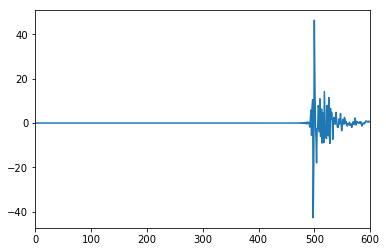

(96000.0, 144000.0)

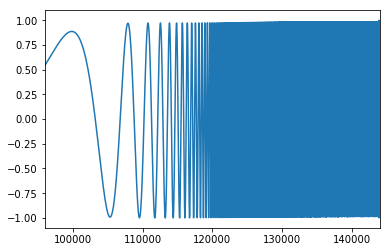

In [626]:
plt.plot(s.sweep)
N = s.sweep.shape[0]
plt.xlim(N/2, 3*N/4)